<a href="https://colab.research.google.com/github/shahrul-amin/Loan-Approval-and-Credit-Scoring-Models-Comparison/blob/main/auto_loan_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, roc_auc_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_curve, precision_recall_curve, auc,
    classification_report
)
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble import (
    RandomForestRegressor, GradientBoostingRegressor,
    RandomForestClassifier, GradientBoostingClassifier
)
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [3]:
df_credit = pd.read_csv('/content/drive/MyDrive/auto_loan/malaysian_credit_scoring_data.csv')
df_loan = pd.read_csv('/content/drive/MyDrive/auto_loan/malaysian_loan_approval_data.csv')

print(f'Credit data: {df_credit.shape}')
print(f'Loan data: {df_loan.shape}')

Credit data: (100000, 27)
Loan data: (100000, 29)


In [4]:
X_credit = df_credit.drop(['ApplicationDate', 'CreditScoreCategory', 'CreditScore', 'CCRISStatus'], axis=1)
y_credit = df_credit['CreditScore']

categorical_features_credit = ['EmploymentStatus', 'EmploymentSector', 'EducationLevel', 'MaritalStatus', 'HomeOwnership']
numerical_features_credit = ['Age', 'MonthlyIncome', 'AnnualIncome', 'WorkExperience', 'EPFMonthlyContribution',
                             'EPFBalance', 'NumCreditFacilities', 'OutstandingFacilities', 'CreditCardLimit',
                             'CreditCardBalance', 'CreditUtilization', 'ExistingLoanCommitments',
                             'PaymentHistoryScore', 'CreditHistoryLength', 'BankingRelationship',
                             'NumDependents', 'SavingsBalance', 'OwnsProperty']

X_credit_encoded = X_credit.copy()
label_encoders_credit = {}
for col in categorical_features_credit:
    le = LabelEncoder()
    X_credit_encoded[col] = le.fit_transform(X_credit[col].astype(str))
    label_encoders_credit[col] = le

scalers_credit = {}
for col in numerical_features_credit:
    scaler = StandardScaler()
    X_credit_encoded[col] = scaler.fit_transform(X_credit_encoded[[col]])
    scalers_credit[col] = scaler

X_train_credit, X_test_credit, y_train_credit, y_test_credit = train_test_split(
    X_credit_encoded, y_credit, test_size=0.2, random_state=42
)

print(f'Credit training: {X_train_credit.shape}')
print(f'Credit testing: {X_test_credit.shape}')

Credit training: (80000, 23)
Credit testing: (20000, 23)


In [5]:
X_loan = df_loan.drop(['ApplicationDate', 'CreditScoreCategory', 'LoanApproved'], axis=1)
y_loan = df_loan['LoanApproved']

categorical_features_loan = ['EmploymentStatus', 'EmploymentSector', 'EducationLevel', 'LoanType', 'MaritalStatus', 'HomeOwnership']

X_loan_encoded = X_loan.copy()
label_encoders_loan = {}
for col in categorical_features_loan:
    le = LabelEncoder()
    X_loan_encoded[col] = le.fit_transform(X_loan[col].astype(str))
    label_encoders_loan[col] = le

X_train_loan, X_test_loan, y_train_loan, y_test_loan = train_test_split(
    X_loan_encoded, y_loan, test_size=0.2, random_state=42, stratify=y_loan
)

print(f'Loan training: {X_train_loan.shape}')
print(f'Loan testing: {X_test_loan.shape}')
print(f'Approval rate: {y_train_loan.mean():.2%}')

Loan training: (80000, 26)
Loan testing: (20000, 26)
Approval rate: 66.06%


In [6]:
regression_models = {
    'XGBoost': XGBRegressor(max_depth=8, learning_rate=0.05, n_estimators=1000, random_state=42, n_jobs=-1),
    'Random Forest': RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0, random_state=42),
    'SVR': SVR(kernel='rbf', C=100, gamma='scale')
}

credit_results = {}

for name, model in regression_models.items():
    print(f'Training {name}...')
    model.fit(X_train_credit, y_train_credit)
    y_pred = model.predict(X_test_credit)
    y_pred = np.clip(y_pred, 300, 850)

    mae = mean_absolute_error(y_test_credit, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_credit, y_pred))
    r2 = r2_score(y_test_credit, y_pred)

    credit_results[name] = {
        'model': model,
        'predictions': y_pred,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

    print(f'{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}\n')

credit_metrics_df = pd.DataFrame({
    name: {
        'MAE': results['MAE'],
        'RMSE': results['RMSE'],
        'R2': results['R2']
    }
    for name, results in credit_results.items()
}).T

print(credit_metrics_df)

Training XGBoost...
XGBoost - MAE: 24.40, RMSE: 30.61, R2: 0.8721

Training Random Forest...
Random Forest - MAE: 24.57, RMSE: 30.83, R2: 0.8702

Training Gradient Boosting...
Gradient Boosting - MAE: 23.84, RMSE: 29.92, R2: 0.8778

Training Linear Regression...
Linear Regression - MAE: 26.33, RMSE: 33.17, R2: 0.8498

Training Ridge...
Ridge - MAE: 26.33, RMSE: 33.17, R2: 0.8498

Training SVR...
SVR - MAE: 25.48, RMSE: 32.07, R2: 0.8596

                         MAE       RMSE        R2
XGBoost            24.397936  30.613670  0.872095
Random Forest      24.569746  30.834529  0.870242
Gradient Boosting  23.841343  29.921798  0.877811
Linear Regression  26.333324  33.173382  0.849811
Ridge              26.333532  33.173311  0.849812
SVR                25.482654  32.071158  0.859626


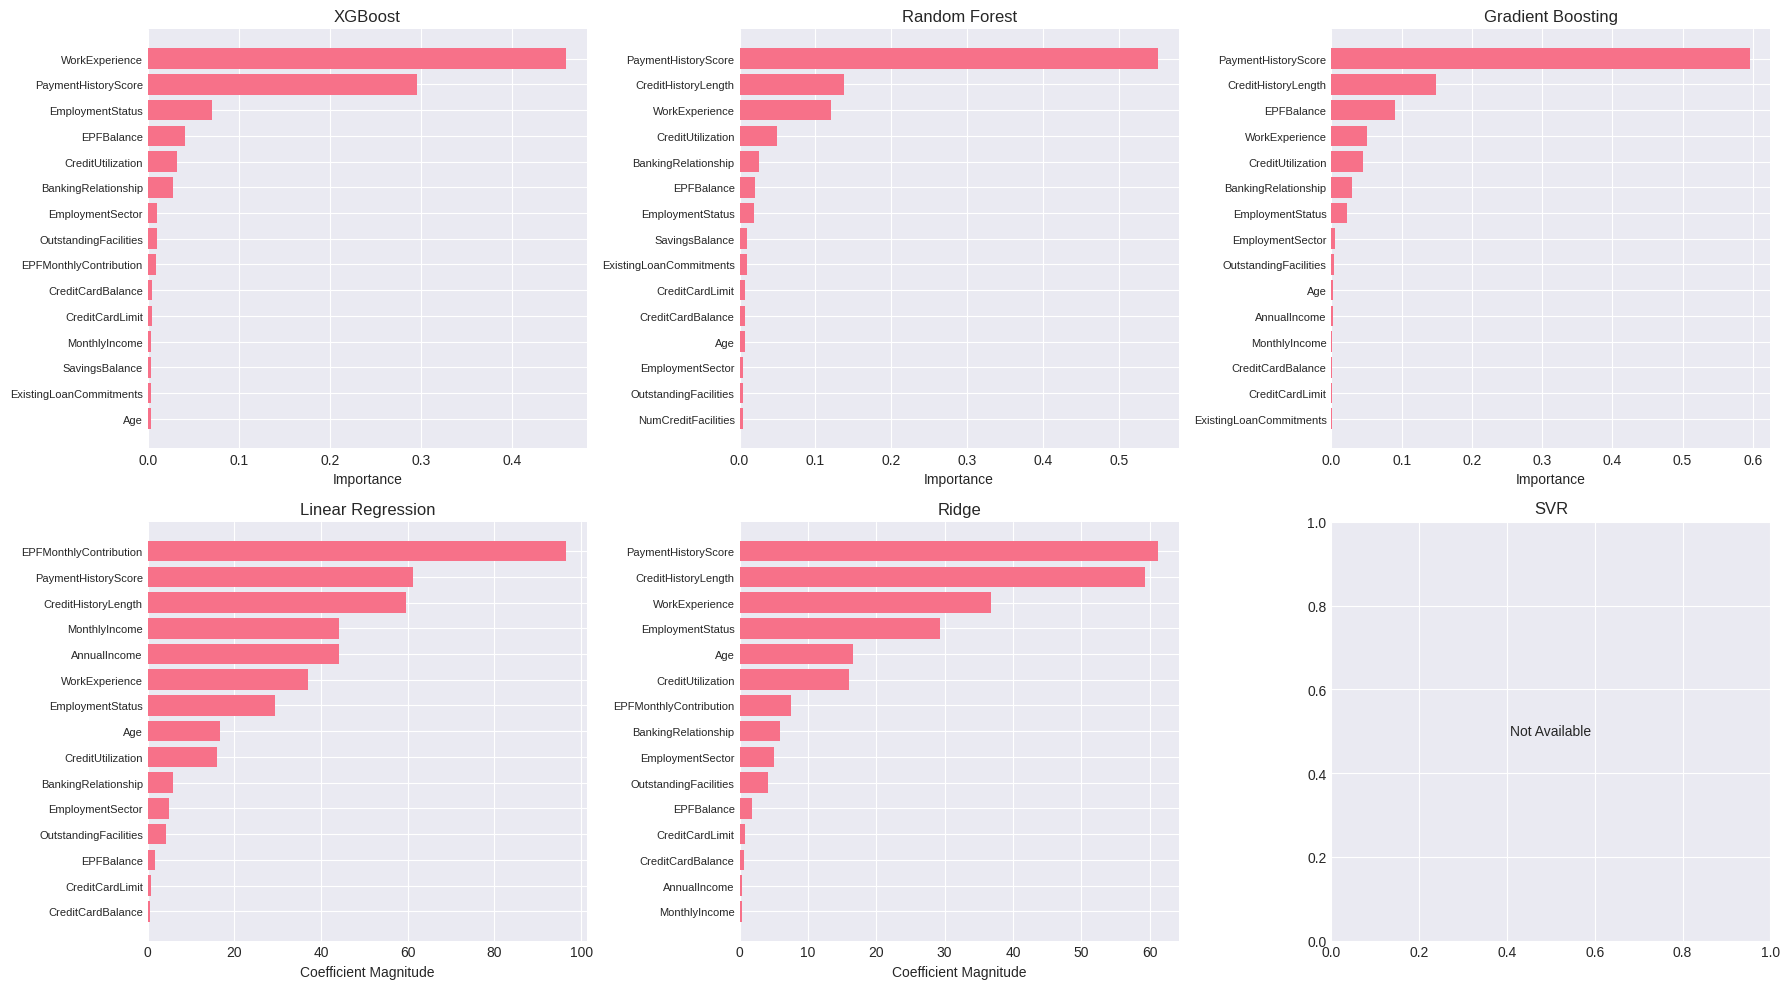

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, results) in enumerate(credit_results.items()):
    model = results['model']

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train_credit.columns
        indices = np.argsort(importances)[-15:]

        axes[idx].barh(range(len(indices)), importances[indices])
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
        axes[idx].set_title(f'{name}')
        axes[idx].set_xlabel('Importance')
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_)
        feature_names = X_train_credit.columns
        indices = np.argsort(importances)[-15:]

        axes[idx].barh(range(len(indices)), importances[indices])
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
        axes[idx].set_title(f'{name}')
        axes[idx].set_xlabel('Coefficient Magnitude')
    else:
        axes[idx].text(0.5, 0.5, 'Not Available', ha='center', va='center')
        axes[idx].set_title(f'{name}')

plt.tight_layout()
plt.savefig('credit_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

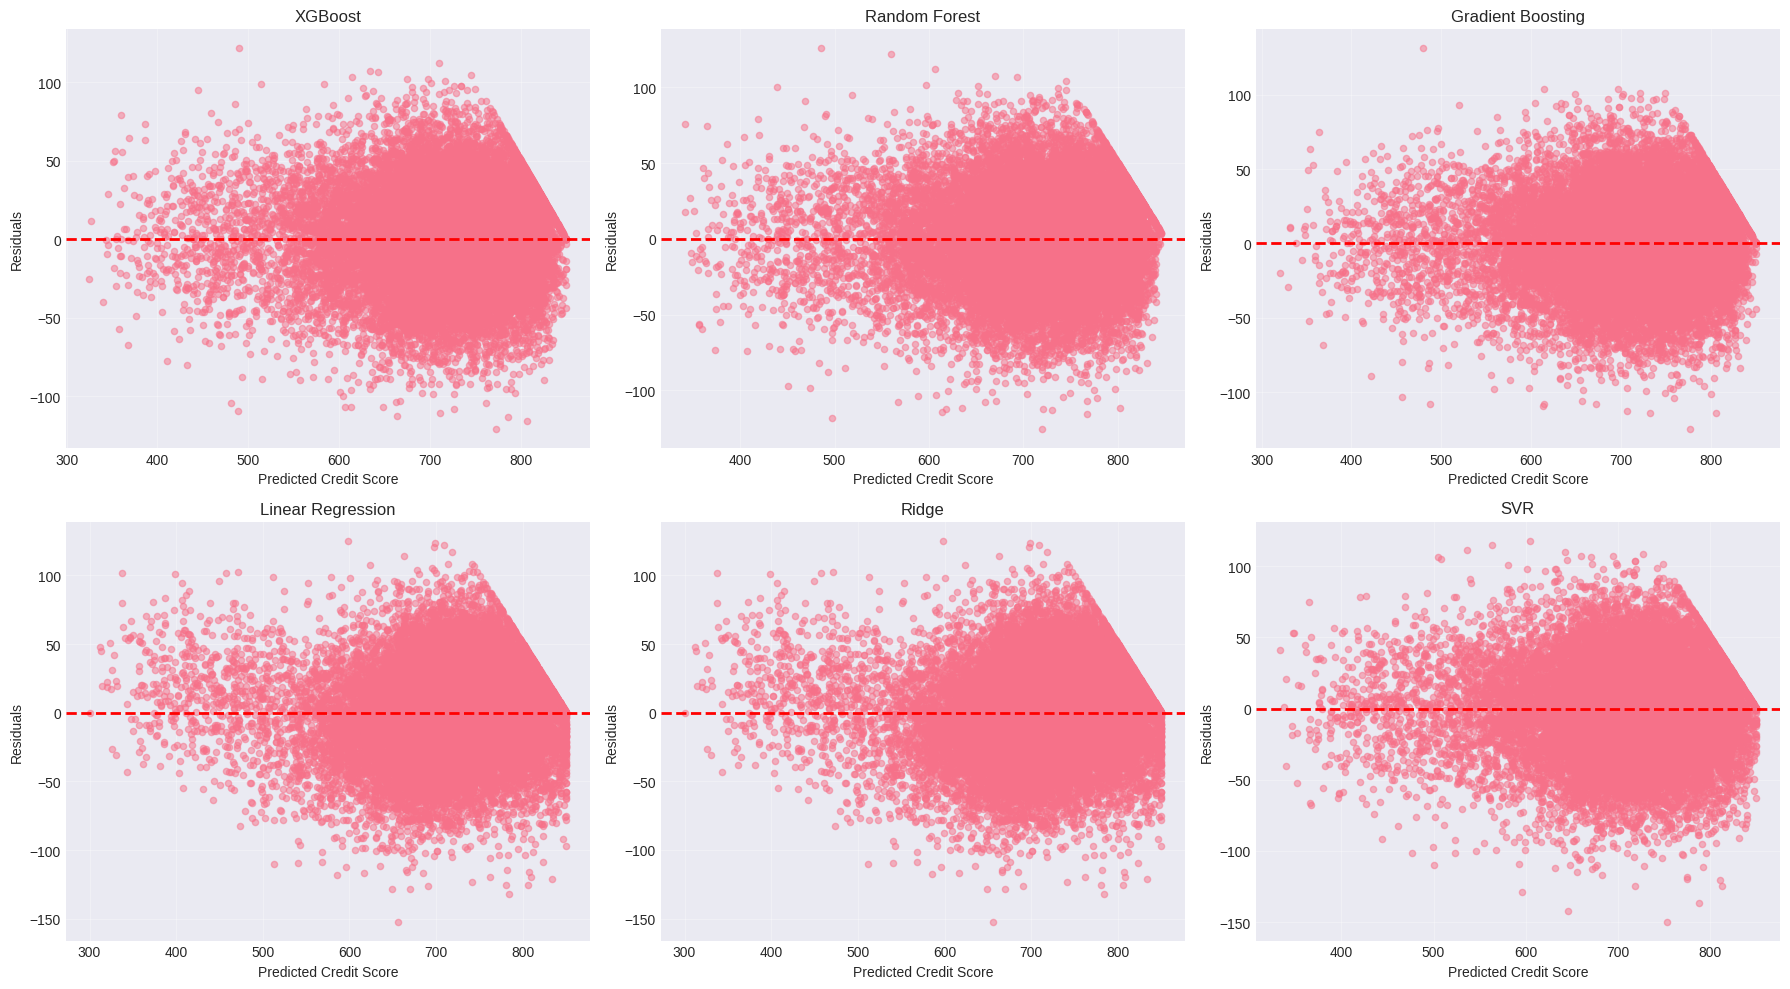

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, results) in enumerate(credit_results.items()):
    y_pred = results['predictions']
    residuals = y_test_credit - y_pred

    axes[idx].scatter(y_pred, residuals, alpha=0.5, s=20)
    axes[idx].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[idx].set_xlabel('Predicted Credit Score')
    axes[idx].set_ylabel('Residuals')
    axes[idx].set_title(f'{name}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('credit_residuals.png', dpi=300, bbox_inches='tight')
plt.show()

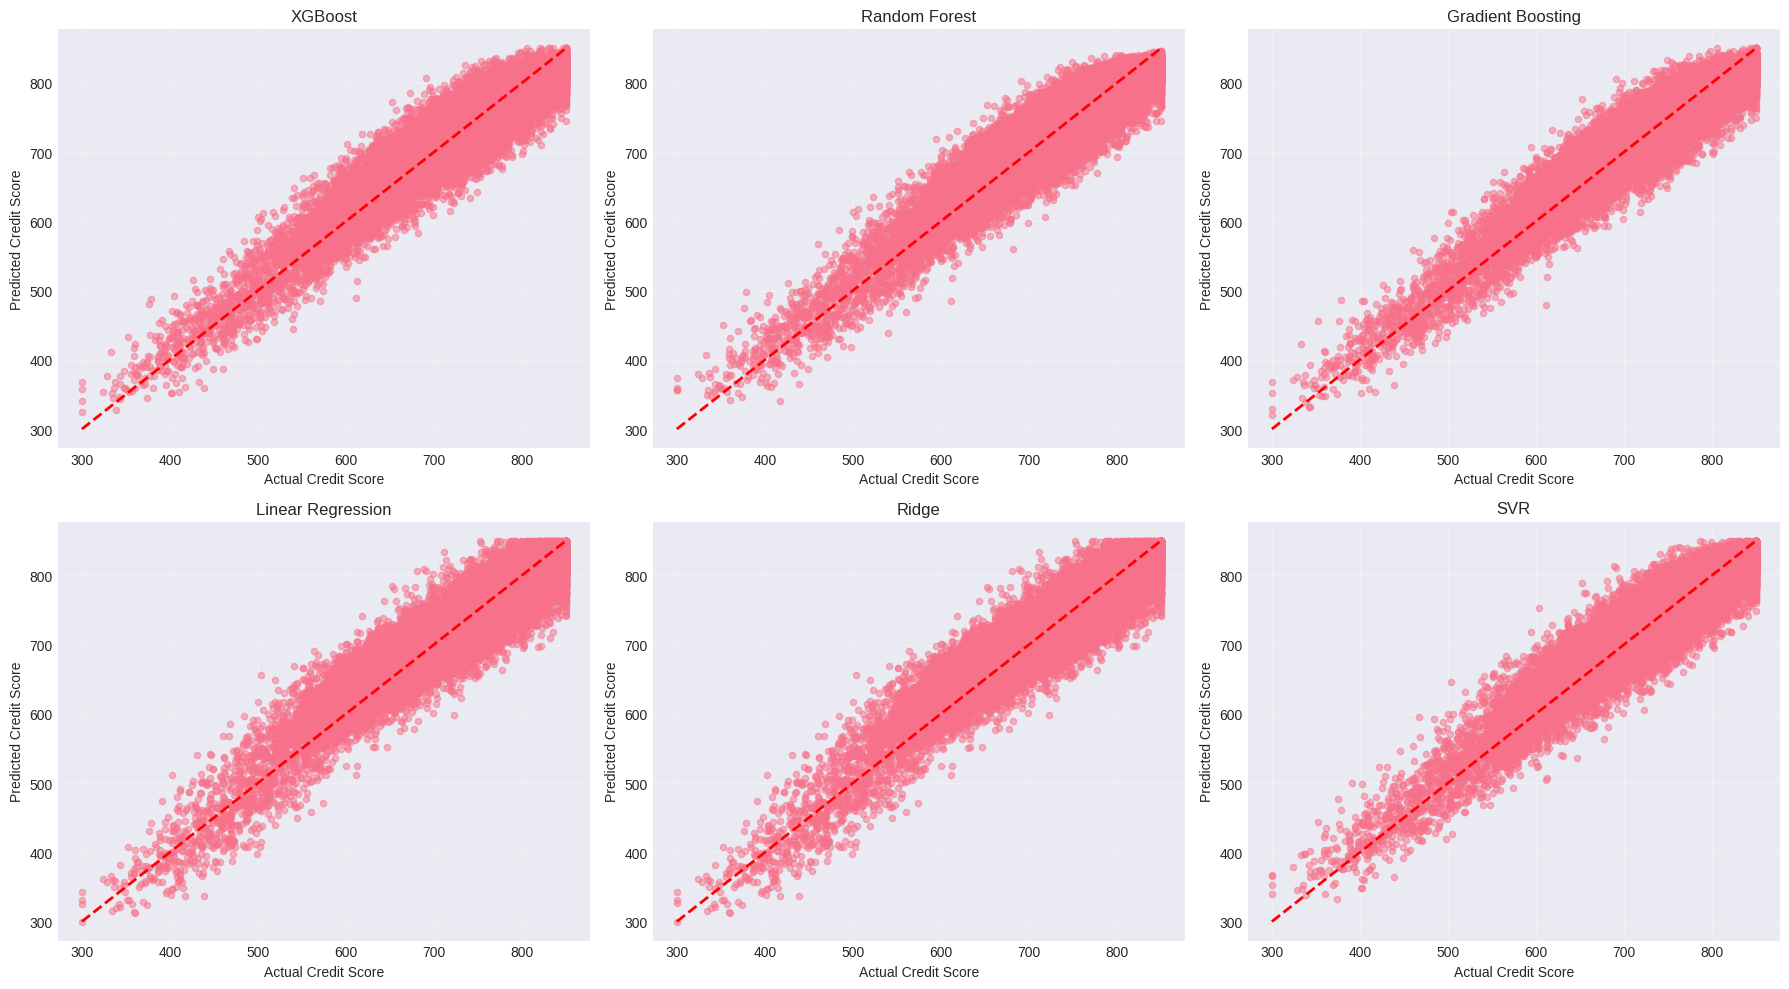

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, results) in enumerate(credit_results.items()):
    y_pred = results['predictions']

    axes[idx].scatter(y_test_credit, y_pred, alpha=0.5, s=20)
    axes[idx].plot([300, 850], [300, 850], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Credit Score')
    axes[idx].set_ylabel('Predicted Credit Score')
    axes[idx].set_title(f'{name}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('credit_predicted_vs_actual.png', dpi=300, bbox_inches='tight')
plt.show()

In [10]:
classification_models = {
    'MLP': MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=30, early_stopping=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(max_depth=8, learning_rate=0.05, n_estimators=1000, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM': SVC(kernel='rbf', C=1.0, probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=15, random_state=42)
}

loan_results = {}

for name, model in classification_models.items():
    print(f'Training {name}...')
    model.fit(X_train_loan, y_train_loan)
    y_pred = model.predict(X_test_loan)
    y_pred_proba = model.predict_proba(X_test_loan)[:, 1]

    accuracy = accuracy_score(y_test_loan, y_pred)
    roc_auc = roc_auc_score(y_test_loan, y_pred_proba)
    f1 = f1_score(y_test_loan, y_pred)
    precision = precision_score(y_test_loan, y_pred)
    recall = recall_score(y_test_loan, y_pred)

    loan_results[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'Accuracy': accuracy,
        'ROC-AUC': roc_auc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

    print(f'{name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}, F1: {f1:.4f}\n')

loan_metrics_df = pd.DataFrame({
    name: {
        'Accuracy': results['Accuracy'],
        'ROC-AUC': results['ROC-AUC'],
        'F1': results['F1'],
        'Precision': results['Precision'],
        'Recall': results['Recall']
    }
    for name, results in loan_results.items()
}).T

print(loan_metrics_df)

Training MLP...
MLP - Accuracy: 0.8548, ROC-AUC: 0.9077, F1: 0.8951

Training Random Forest...
Random Forest - Accuracy: 0.9291, ROC-AUC: 0.9817, F1: 0.9463

Training XGBoost...
XGBoost - Accuracy: 0.9254, ROC-AUC: 0.9821, F1: 0.9433

Training Logistic Regression...
Logistic Regression - Accuracy: 0.8464, ROC-AUC: 0.8989, F1: 0.8896

Training SVM...
SVM - Accuracy: 0.8091, ROC-AUC: 0.8652, F1: 0.8692

Training Gradient Boosting...
Gradient Boosting - Accuracy: 0.9317, ROC-AUC: 0.9838, F1: 0.9481

Training Decision Tree...
Decision Tree - Accuracy: 0.9133, ROC-AUC: 0.9385, F1: 0.9342

                     Accuracy   ROC-AUC        F1  Precision    Recall
MLP                   0.85480  0.907652  0.895064   0.856441  0.937334
Random Forest         0.92905  0.981675  0.946256   0.947081  0.945433
XGBoost               0.92540  0.982057  0.943326   0.946923  0.939756
Logistic Regression   0.84635  0.898948  0.889568   0.846928  0.936729
SVM                   0.80905  0.865211  0.869199   0.

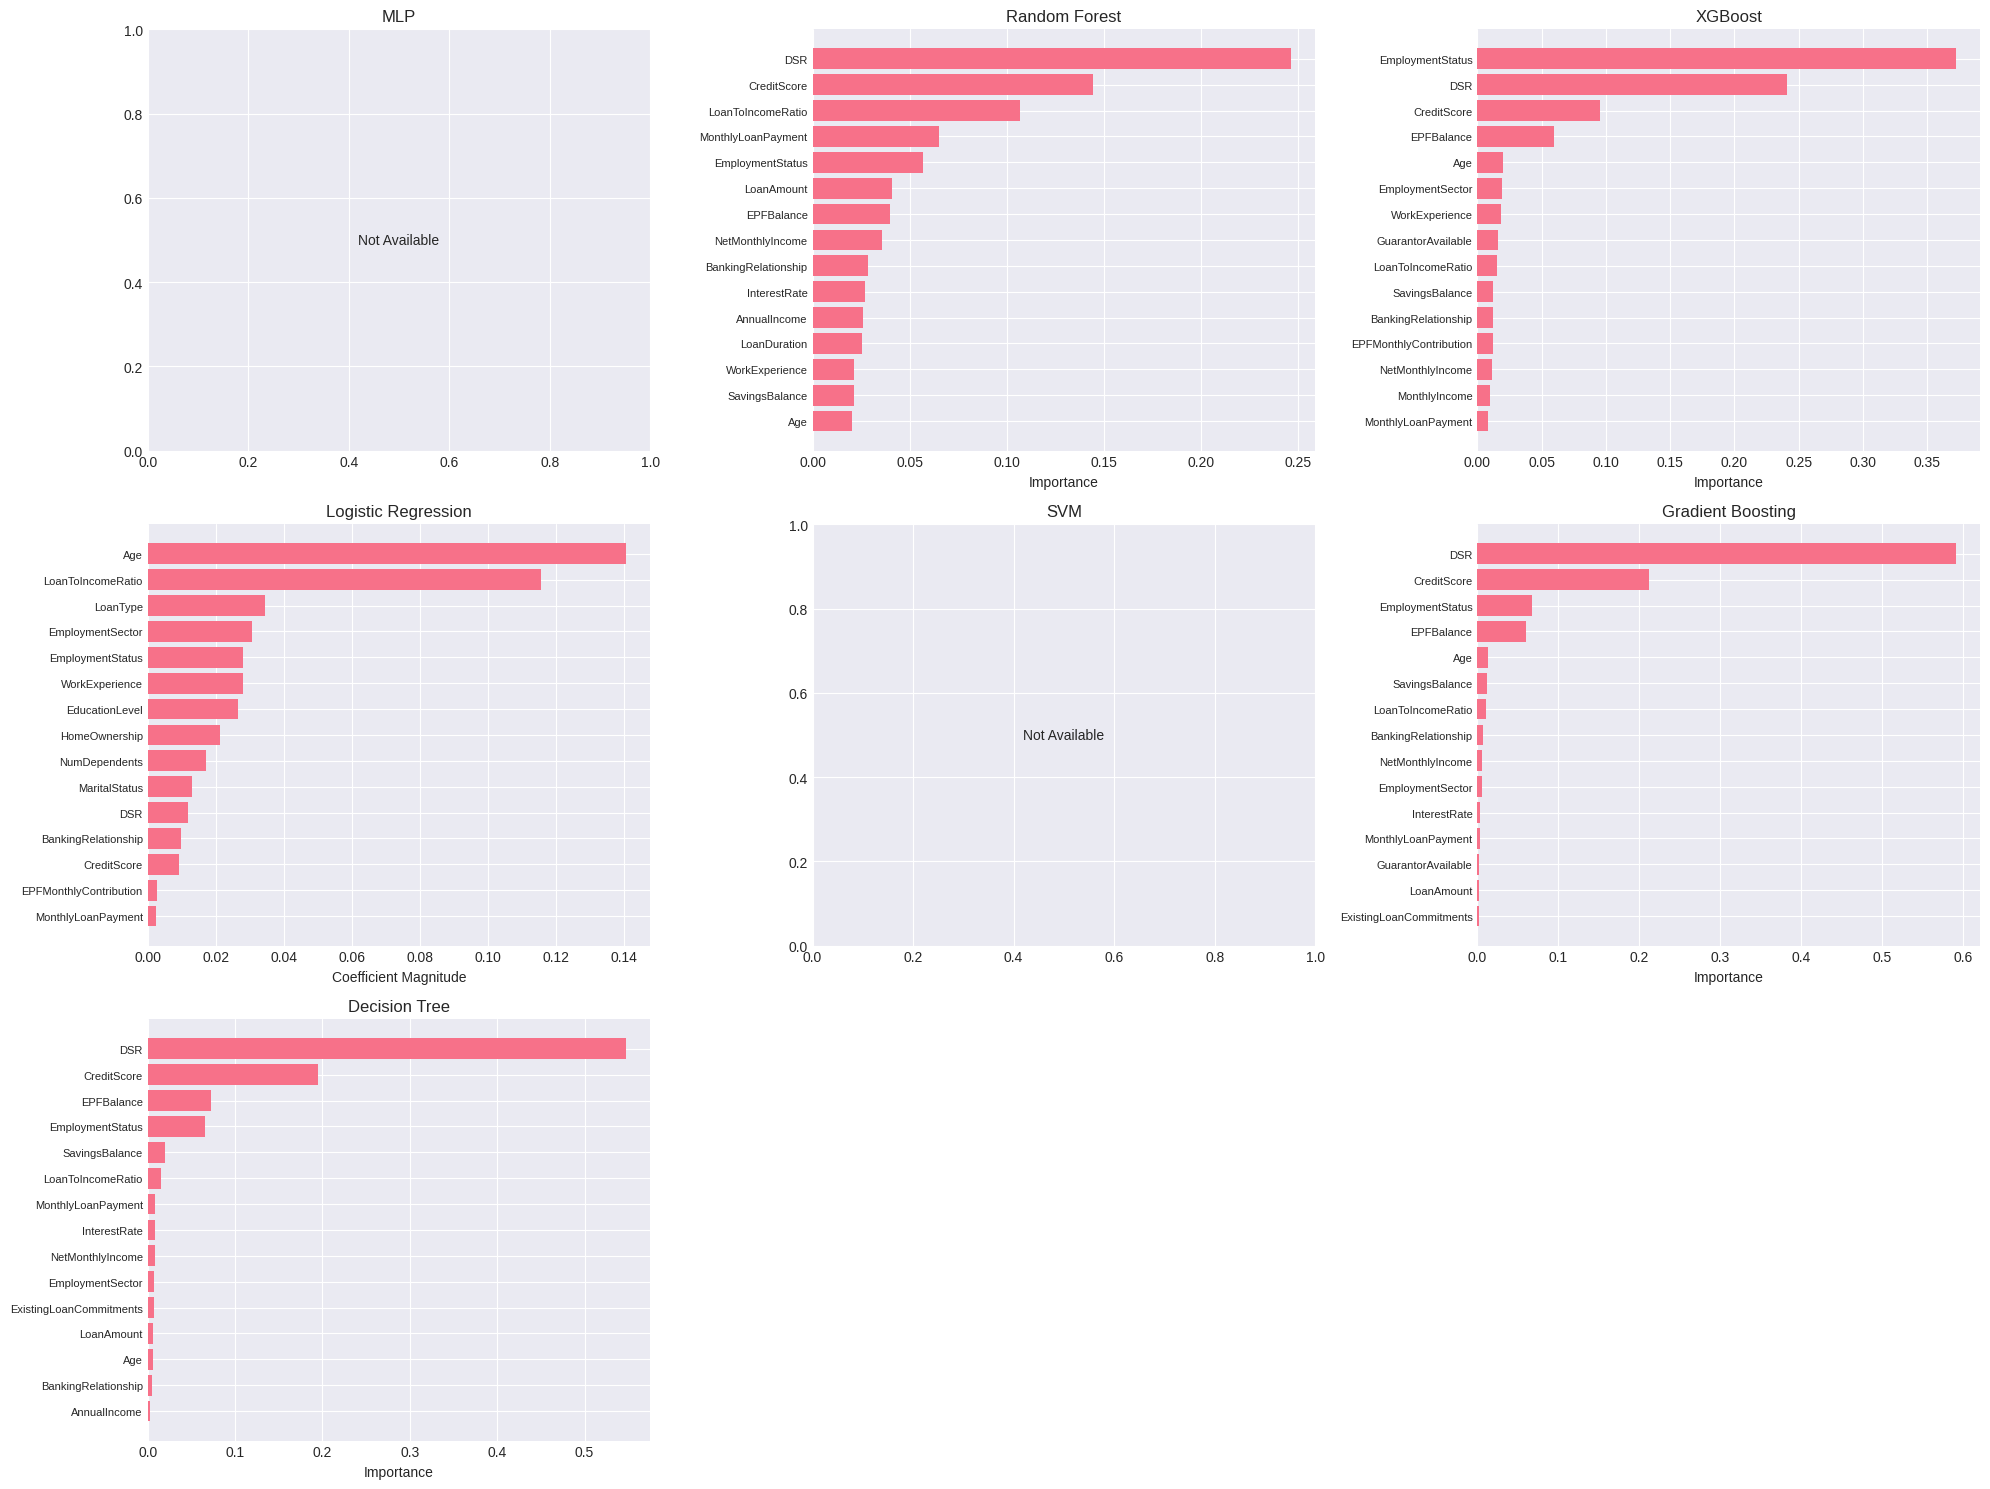

In [11]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for idx, (name, results) in enumerate(loan_results.items()):
    model = results['model']

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X_train_loan.columns
        indices = np.argsort(importances)[-15:]

        axes[idx].barh(range(len(indices)), importances[indices])
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
        axes[idx].set_title(f'{name}')
        axes[idx].set_xlabel('Importance')
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
        feature_names = X_train_loan.columns
        indices = np.argsort(importances)[-15:]

        axes[idx].barh(range(len(indices)), importances[indices])
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels([feature_names[i] for i in indices], fontsize=8)
        axes[idx].set_title(f'{name}')
        axes[idx].set_xlabel('Coefficient Magnitude')
    else:
        axes[idx].text(0.5, 0.5, 'Not Available', ha='center', va='center')
        axes[idx].set_title(f'{name}')

for i in range(len(loan_results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('loan_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

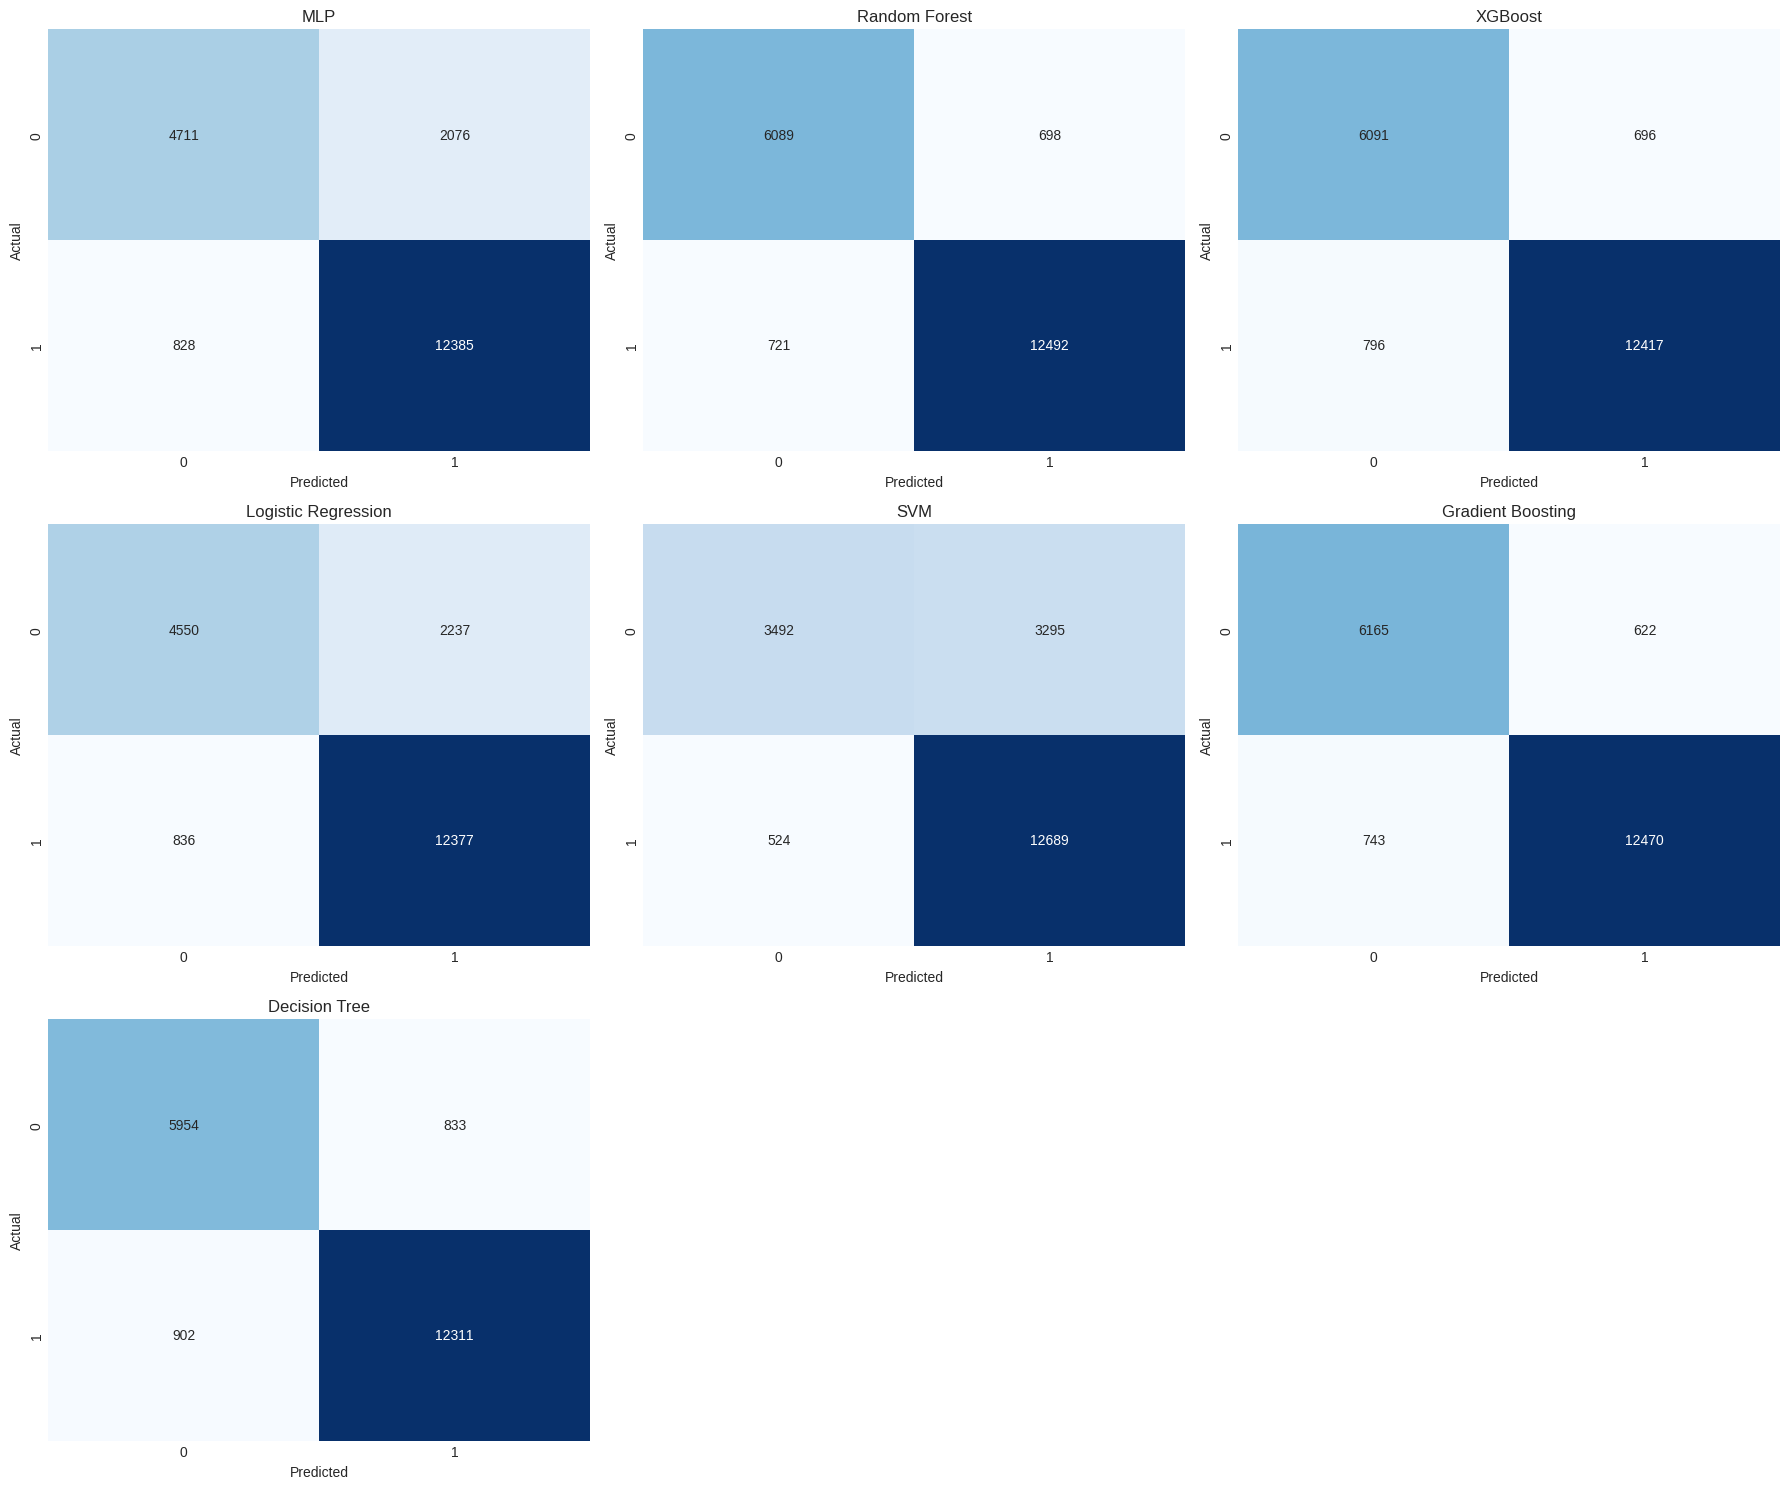

In [12]:
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, (name, results) in enumerate(loan_results.items()):
    cm = confusion_matrix(y_test_loan, results['predictions'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], cbar=False)
    axes[idx].set_title(f'{name}')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

for i in range(len(loan_results), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.savefig('loan_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

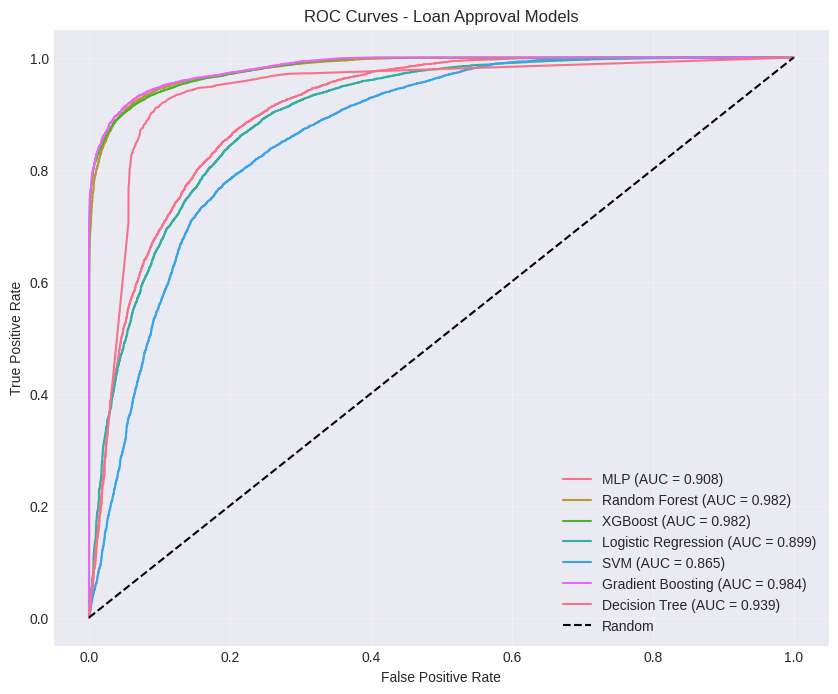

In [13]:
plt.figure(figsize=(10, 8))

for name, results in loan_results.items():
    fpr, tpr, _ = roc_curve(y_test_loan, results['probabilities'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Loan Approval Models')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.savefig('loan_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

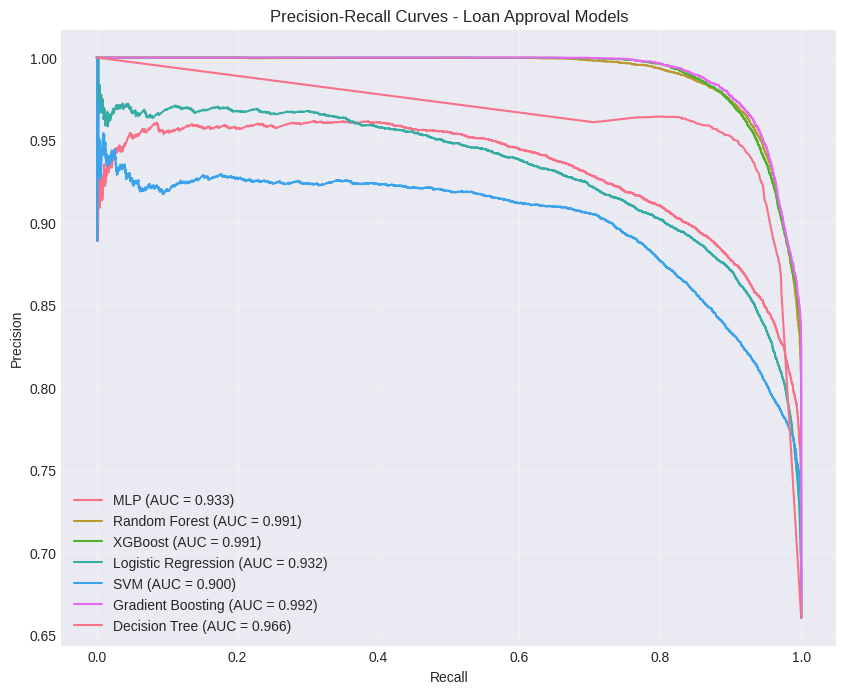

In [14]:
plt.figure(figsize=(10, 8))

for name, results in loan_results.items():
    precision, recall, _ = precision_recall_curve(y_test_loan, results['probabilities'])
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC = {pr_auc:.3f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Loan Approval Models')
plt.legend(loc='lower left')
plt.grid(True, alpha=0.3)
plt.savefig('loan_precision_recall_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [15]:
print('=== CREDIT SCORE MODEL COMPARISON ===')
print(credit_metrics_df.sort_values('R2', ascending=False))
print('\n=== LOAN APPROVAL MODEL COMPARISON ===')
print(loan_metrics_df.sort_values('ROC-AUC', ascending=False))

=== CREDIT SCORE MODEL COMPARISON ===
                         MAE       RMSE        R2
Gradient Boosting  23.841343  29.921798  0.877811
XGBoost            24.397936  30.613670  0.872095
Random Forest      24.569746  30.834529  0.870242
SVR                25.482654  32.071158  0.859626
Ridge              26.333532  33.173311  0.849812
Linear Regression  26.333324  33.173382  0.849811

=== LOAN APPROVAL MODEL COMPARISON ===
                     Accuracy   ROC-AUC        F1  Precision    Recall
Gradient Boosting     0.93175  0.983758  0.948109   0.952490  0.943768
XGBoost               0.92540  0.982057  0.943326   0.946923  0.939756
Random Forest         0.92905  0.981675  0.946256   0.947081  0.945433
Decision Tree         0.91325  0.938545  0.934173   0.936625  0.931734
MLP                   0.85480  0.907652  0.895064   0.856441  0.937334
Logistic Regression   0.84635  0.898948  0.889568   0.846928  0.936729
SVM                   0.80905  0.865211  0.869199   0.793856  0.960342
